<a href="https://colab.research.google.com/github/sambhav-antriksh/Fourier_Neural_Network/blob/main/Naiver_Stokes_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating dataset with parameters:
 Nx=64, Ny=64, nu=0.0001, dt=0.001, T=2.0, steps=2000, n_samples=3


Generating samples: 100%|██████████| 3/3 [00:25<00:00,  8.63s/it]


Baseline MSE (first 10 samples): [0.47939813 1.1503643  0.7715324 ]
MSE mean: 0.80043155 std: 0.27468196
Saved dataset to combined_NS_dataset_new.npz


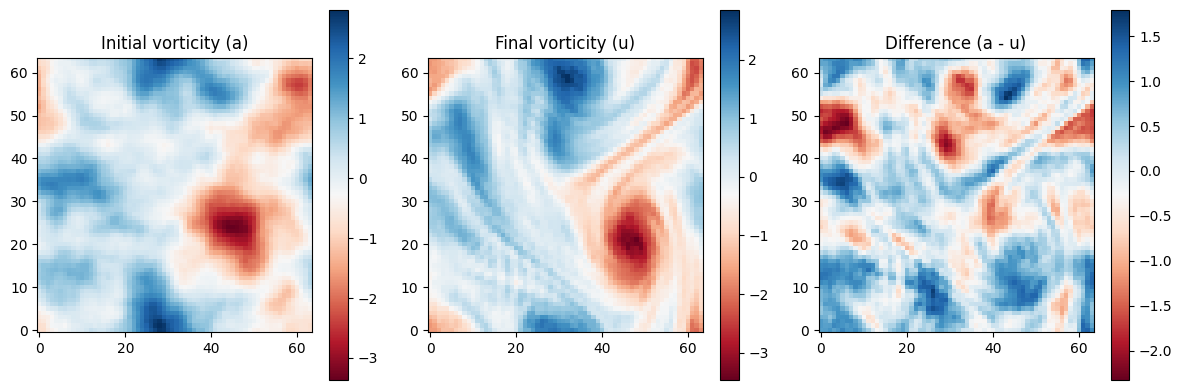

In [ ]:
"""
generate_ns2d_dataset.py

Generate 2D Navier-Stokes (vorticity) dataset for FNO training.
Saves npz with arrays:
  a: (N_samples, Nx, Ny)  # initial vorticity
  u: (N_samples, Nx, Ny)  # vorticity at final time T

Requirements: numpy, scipy (for fftpack optional), matplotlib (optional)
Run: python generate_ns2d_dataset.py
"""

import numpy as np
import os
from tqdm import trange
import matplotlib.pyplot as plt
# ============================================================
# PARAMETERS
# ============================================================
Nx = 64
Ny = 64
nu = 1e-4
dt = 1e-3
T = 2.0
nsteps = int(T / dt)
n_samples = 3
seed_base = 1234

# ============================================================
# GRID DEFINITION (this was missing)
# ============================================================
# 2D periodic grid in [0,1]^2
x = np.linspace(0, 1, Nx, endpoint=False)
y = np.linspace(0, 1, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")

# spectral initial condition parameters
spec_power = 2.5   # controls spectral decay; larger -> smoother initial fields
k0 = 2.0           # typical wavenumber scale (peak of power)

# Dealiasing cutoff (2/3 rule)
dealias_cut = int(np.floor(min(Nx, Ny) / 3.0))

# ----------------------------
# Helper spectral functions
# ----------------------------
kx = np.fft.fftfreq(Nx) * Nx    # integer wave numbers
ky = np.fft.fftfreq(Ny) * Ny
kxv = kx[:, None]               # shape (Nx,1)
kyv = ky[None, :]               # shape (1,Ny)
k2 = (kxv**2 + kyv**2)
k2[0,0] = 1.0  # avoid divide-by-zero later; we'll handle ψ_hat at k=0 separately

def dealias_mask(Nx, Ny, cutoff=None):
    if cutoff is None:
        cutoff = int(np.floor(min(Nx, Ny) / 3.0))
    kx = np.fft.fftfreq(Nx) * Nx
    ky = np.fft.fftfreq(Ny) * Ny
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    mask = (np.abs(KX) <= cutoff) & (np.abs(KY) <= cutoff)
    return mask

mask = dealias_mask(Nx, Ny, dealias_cut)

# spectral derivatives (in Fourier domain)
ikx = 1j * kxv
iky = 1j * kyv

# ----------------------------
# Function: velocity from vorticity via streamfunction
# ----------------------------
def vorticity_to_velocity(omega):
    """
    omega : (Nx, Ny) physical-space vorticity
    returns u,v arrays of shape (Nx, Ny)
    using streamfunction psi satisfying Laplacian(psi) = omega
    convention: u = (-d_y psi, d_x psi)
    """
    omega_hat = np.fft.fft2(omega)
    psi_hat = - omega_hat / k2
    psi_hat[0,0] = 0.0 + 0.0j   # mean of psi arbitrary (set 0)
    # derivatives in Fourier space
    u_hat = - (iky * psi_hat)   # -d_y psi -> u_x
    v_hat = (ikx * psi_hat)     # d_x psi -> u_y
    u = np.fft.ifft2(u_hat).real
    v = np.fft.ifft2(v_hat).real
    return u, v

# ----------------------------
# Nonlinear term: u · ∇ ω
# ----------------------------
def nonlinear_term(omega):
    u, v = vorticity_to_velocity(omega)
    # compute derivatives of omega in spectral space for accuracy
    omega_hat = np.fft.fft2(omega)
    domega_dx = np.fft.ifft2(ikx * omega_hat).real
    domega_dy = np.fft.ifft2(iky * omega_hat).real
    return u * domega_dx + v * domega_dy

# ----------------------------
# RK4 stepping (explicit) for ∂t ω = - u·∇ω + ν Δ ω + forcing(optional)
# We implement dealiasing by truncating high modes when computing nonlinear term in spectral domain.
# ----------------------------
def rk4_step(omega, dt, nu, forcing=None):
    global k2, mask  # <-- add this line

    # k1
    N1 = -nonlinear_term(omega)
    if forcing is not None:
        N1 = N1 + forcing
    L1 = nu * (np.fft.ifft2(-k2 * np.fft.fft2(omega)).real)
    k1 = N1 + L1

    # k2
    w2 = omega + 0.5 * dt * k1
    N2 = -nonlinear_term(w2)
    if forcing is not None:
        N2 = N2 + forcing
    L2 = nu * (np.fft.ifft2(-k2 * np.fft.fft2(w2)).real)
    k2_term = N2 + L2

    # k3
    w3 = omega + 0.5 * dt * k2_term
    N3 = -nonlinear_term(w3)
    if forcing is not None:
        N3 = N3 + forcing
    L3 = nu * (np.fft.ifft2(-k2 * np.fft.fft2(w3)).real)
    k3 = N3 + L3

    # k4
    w4 = omega + dt * k3
    N4 = -nonlinear_term(w4)
    if forcing is not None:
        N4 = N4 + forcing
    L4 = nu * (np.fft.ifft2(-k2 * np.fft.fft2(w4)).real)
    k4 = N4 + L4

    omega_new = omega + (dt / 6.0) * (k1 + 2*k2_term + 2*k3 + k4)

    # optional dealiasing: zero out high modes
    omega_hat = np.fft.fft2(omega_new)
    omega_hat *= mask
    omega_new = np.fft.ifft2(omega_hat).real

    return omega_new


# ----------------------------
# Initial condition generator (random spectral field)
# ----------------------------
def random_vorticity_field(Nx, Ny, spec_power=2.5, k0=2.0, seed=None):
    rng = np.random.RandomState(seed)
    # create random complex Fourier coefficients with amplitude ~ (k^2 + k0^2)^(-spec_power/2)
    KX, KY = np.meshgrid(np.fft.fftfreq(Nx) * Nx, np.fft.fftfreq(Ny) * Ny, indexing='ij')
    K2 = KX**2 + KY**2
    amplitude = (K2 + (k0**2)) ** (-spec_power / 2.0)
    # random phases and gaussian amplitude
    real = rng.normal(size=(Nx, Ny))
    imag = rng.normal(size=(Nx, Ny))
    coeff = (real + 1j*imag) * amplitude
    coeff[0,0] = 0.0 + 0.0j   # zero mean vorticity (optional)
    # inverse fft to physical space
    field = np.fft.ifft2(coeff).real
    # normalize to have unit std
    field = field / np.std(field)
    # scale a bit
    field = field * 1.0
    return field

# ----------------------------
# Main data generation loop
# ----------------------------
def generate_dataset(n_samples, Nx, Ny, dt, nsteps, nu, seed_base=0, show_progress=True):
    A = np.zeros((n_samples, Nx, Ny), dtype=np.float32)
    U = np.zeros((n_samples, Nx, Ny), dtype=np.float32)

    samples_to_visualize = [2]  # we'll plot the first sample's evolution later

    for i in trange(n_samples, desc="Generating samples"):
        seed = seed_base + i
        w0 = random_vorticity_field(Nx, Ny, spec_power=spec_power, k0=k0, seed=seed)
        omega = w0.copy()
        # integrate in time
        for tstep in range(nsteps):
            # you can add small forcing/noise if you want persistent turbulence:
            # forcing = 0.001 * np.sin(2*np.pi*(X + Y))  # example
            forcing = 0.001 * np.sin(2*np.pi*X) * np.cos(2*np.pi*Y)

            omega = rk4_step(omega, dt, nu, forcing=None)

            # quick CFL-ish check: if blow up occurs (nan), break and re-initialize smaller dt
            if not np.isfinite(omega).all():
                raise RuntimeError(f"Blow-up at sample {i}, tstep {tstep}. Try reducing dt or increasing viscosity.")

        A[i] = w0
        U[i] = omega

    return A, U

if __name__ == "__main__":
    print("Generating dataset with parameters:")
    print(f" Nx={Nx}, Ny={Ny}, nu={nu}, dt={dt}, T={T}, steps={nsteps}, n_samples={n_samples}")

    A, U = generate_dataset(n_samples, Nx, Ny, dt, nsteps, nu, seed_base=seed_base)

    # baseline statistics to check non-triviality
    mse_per_sample = np.mean((A - U)**2, axis=(1,2))
    print("Baseline MSE (first 10 samples):", mse_per_sample[:10])
    print("MSE mean:", mse_per_sample.mean(), "std:", mse_per_sample.std())

    # save
    np.savez_compressed(save_path, a=A, u=U)
    print(f"Saved dataset to {save_path}")

    # quick sanity plot for a sample
    idx = 0
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    im0 = ax[0].imshow(A[idx], cmap='RdBu', origin='lower')
    ax[0].set_title("Initial vorticity (a)")
    plt.colorbar(im0, ax=ax[0])
    im1 = ax[1].imshow(U[idx], cmap='RdBu', origin='lower')
    ax[1].set_title("Final vorticity (u)")
    plt.colorbar(im1, ax=ax[1])
    im2 = ax[2].imshow(A[idx]-U[idx], cmap='RdBu', origin='lower')
    ax[2].set_title("Difference (a - u)")
    plt.colorbar(im2, ax=ax[2])
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

data = np.load("combined_NS_dataset_new.npz")
a = data["a"]
u = data["u"]

# Flatten across samples and grid points
corr = np.corrcoef(a.flatten(), u.flatten())[0, 1]
print("Overall correlation between a and u:", corr)


Overall correlation between a and u: 0.5989600345997843


In [ ]:
mse_per_sample = np.mean((a - u)**2, axis=(1,2))  # mean over x,y for each sample
mean_mse = np.mean(mse_per_sample)
std_mse = np.std(mse_per_sample)

print(f"Mean MSE: {mean_mse:.6f}, Std: {std_mse:.6f}")


Mean MSE: 0.800432, Std: 0.274682


In [ ]:
import numpy as np
data = np.load("combined_NS_dataset_new.npz")
a, u = data["a"], data["u"]

# overall correlation
corr = np.corrcoef(a.flatten(), u.flatten())[0,1]
mse = np.mean((a - u)**2)
print(f"Temporal separation Δt = 5.0 → Corr = {corr:.3f}, MSE = {mse:.3f}")


Temporal separation Δt = 5.0 → Corr = 0.599, MSE = 0.800


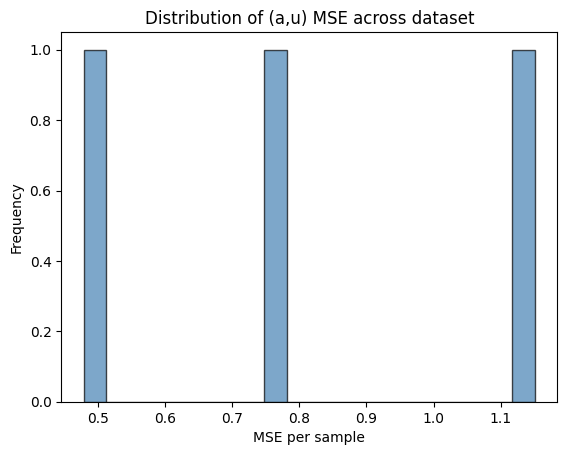

In [ ]:
import matplotlib.pyplot as plt

plt.hist(mse_per_sample, bins=20, color='steelblue', edgecolor='k', alpha=0.7)
plt.xlabel("MSE per sample")
plt.ylabel("Frequency")
plt.title("Distribution of (a,u) MSE across dataset")
plt.show()


Generating dataset with parameters:
 Nx=64, Ny=64, nu=0.0001, dt=0.001, T=2.0, steps=2000, n_samples=3


Generating samples: 100%|██████████| 3/3 [00:34<00:00, 11.34s/it]


Baseline MSE (first 10 samples): [0.4792797 1.1503326 0.7713798]
MSE mean: 0.80033064 std: 0.27471998
✅ Saved dataset to combined_NS_T2_samples.npz


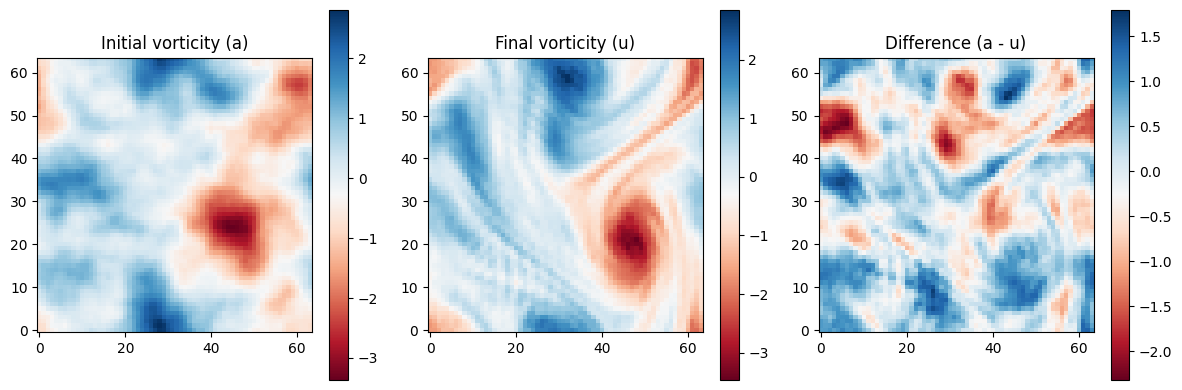

In [ ]:
"""
generate_ns2d_dataset.py

Generate 2D Navier-Stokes (vorticity) dataset for FNO training.
Saves npz with arrays:
  a: (N_samples, Nx, Ny)  # initial vorticity
  u: (N_samples, Nx, Ny)  # vorticity at final time T

Run: python generate_ns2d_dataset.py
"""

import numpy as np
import os
from tqdm import trange
import matplotlib.pyplot as plt

# ============================================================
# PARAMETERS
# ============================================================
Nx = 64
Ny = 64
nu = 1e-4
dt = 1e-3
T = 2.0
nsteps = int(T / dt)
n_samples = 3               # 🧠 change to 10000 later
seed_base = 1234
save_path = "combined_NS_T2_samples.npz"  # 🔹 define explicitly

# ============================================================
# GRID DEFINITION
# ============================================================
# 2D periodic grid in [0,1]^2
x = np.linspace(0, 1, Nx, endpoint=False)
y = np.linspace(0, 1, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")

# ============================================================
# SPECTRAL PARAMETERS
# ============================================================
spec_power = 2.5   # controls spectral decay; larger -> smoother initial fields
k0 = 2.0           # typical wavenumber scale (peak of power)
dealias_cut = int(np.floor(min(Nx, Ny) / 3.0))

# ============================================================
# FOURIER GRID
# ============================================================
kx = np.fft.fftfreq(Nx) * Nx
ky = np.fft.fftfreq(Ny) * Ny
kxv = kx[:, None]
kyv = ky[None, :]
k2 = kxv**2 + kyv**2
k2[0,0] = 1.0  # avoid divide-by-zero

# ============================================================
# DEALIAS MASK
# ============================================================
def dealias_mask(Nx, Ny, cutoff=None):
    if cutoff is None:
        cutoff = int(np.floor(min(Nx, Ny) / 3.0))
    kx = np.fft.fftfreq(Nx) * Nx
    ky = np.fft.fftfreq(Ny) * Ny
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    return (np.abs(KX) <= cutoff) & (np.abs(KY) <= cutoff)

mask = dealias_mask(Nx, Ny, dealias_cut)
ikx = 1j * kxv
iky = 1j * kyv

# ============================================================
# VELOCITY FROM VORTICITY
# ============================================================
def vorticity_to_velocity(omega):
    omega_hat = np.fft.fft2(omega)
    psi_hat = -omega_hat / k2
    psi_hat[0,0] = 0.0 + 0.0j
    u_hat = -iky * psi_hat
    v_hat = ikx * psi_hat
    u = np.fft.ifft2(u_hat).real
    v = np.fft.ifft2(v_hat).real
    return u, v

# ============================================================
# NONLINEAR TERM
# ============================================================
def nonlinear_term(omega):
    u, v = vorticity_to_velocity(omega)
    omega_hat = np.fft.fft2(omega)
    domega_dx = np.fft.ifft2(ikx * omega_hat).real
    domega_dy = np.fft.ifft2(iky * omega_hat).real
    return u * domega_dx + v * domega_dy

# ============================================================
# RK4 INTEGRATOR
# ============================================================
def rk4_step(omega, dt, nu, forcing=None):
    global k2, mask
    def diffusion(omega_field):
        return np.fft.ifft2(-k2 * np.fft.fft2(omega_field)).real

    N1 = -nonlinear_term(omega)
    if forcing is not None:
        N1 += forcing
    L1 = nu * diffusion(omega)
    k1 = N1 + L1

    w2 = omega + 0.5 * dt * k1
    N2 = -nonlinear_term(w2)
    if forcing is not None:
        N2 += forcing
    L2 = nu * diffusion(w2)
    k2_term = N2 + L2

    w3 = omega + 0.5 * dt * k2_term
    N3 = -nonlinear_term(w3)
    if forcing is not None:
        N3 += forcing
    L3 = nu * diffusion(w3)
    k3 = N3 + L3

    w4 = omega + dt * k3
    N4 = -nonlinear_term(w4)
    if forcing is not None:
        N4 += forcing
    L4 = nu * diffusion(w4)
    k4 = N4 + L4

    omega_new = omega + (dt / 6.0) * (k1 + 2*k2_term + 2*k3 + k4)

    # dealias
    omega_hat = np.fft.fft2(omega_new)
    omega_hat *= mask
    return np.fft.ifft2(omega_hat).real

# ============================================================
# RANDOM INITIAL FIELD
# ============================================================
def random_vorticity_field(Nx, Ny, spec_power=2.5, k0=2.0, seed=None):
    rng = np.random.RandomState(seed)
    KX, KY = np.meshgrid(np.fft.fftfreq(Nx) * Nx, np.fft.fftfreq(Ny) * Ny, indexing='ij')
    K2 = KX**2 + KY**2
    amplitude = (K2 + (k0**2)) ** (-spec_power / 2.0)
    coeff = (rng.normal(size=(Nx, Ny)) + 1j * rng.normal(size=(Nx, Ny))) * amplitude
    coeff[0,0] = 0.0 + 0.0j
    field = np.fft.ifft2(coeff).real
    return field / np.std(field)

# ============================================================
# MAIN GENERATOR
# ============================================================
def generate_dataset(n_samples, Nx, Ny, dt, nsteps, nu, seed_base=0, show_progress=True):
    A = np.zeros((n_samples, Nx, Ny), dtype=np.float32)
    U = np.zeros((n_samples, Nx, Ny), dtype=np.float32)
    for i in trange(n_samples, desc="Generating samples"):
        seed = seed_base + i
        w0 = random_vorticity_field(Nx, Ny, spec_power=spec_power, k0=k0, seed=seed)
        omega = w0.copy()

        # 🔹 define steady low-frequency forcing
        forcing = 1e-3 * np.sin(2*np.pi*X) * np.cos(2*np.pi*Y)

        for _ in range(nsteps):
            omega = rk4_step(omega, dt, nu, forcing=forcing)
            if not np.isfinite(omega).all():
                raise RuntimeError(f"Blow-up at sample {i}. Try reducing dt or increasing nu.")

        A[i] = w0
        U[i] = omega
    return A, U

# ============================================================
# MAIN EXECUTION
# ============================================================
if __name__ == "__main__":
    print("Generating dataset with parameters:")
    print(f" Nx={Nx}, Ny={Ny}, nu={nu}, dt={dt}, T={T}, steps={nsteps}, n_samples={n_samples}")

    A, U = generate_dataset(n_samples, Nx, Ny, dt, nsteps, nu, seed_base=seed_base)

    mse_per_sample = np.mean((A - U)**2, axis=(1,2))
    print("Baseline MSE (first 10 samples):", mse_per_sample[:10])
    print("MSE mean:", mse_per_sample.mean(), "std:", mse_per_sample.std())

    np.savez_compressed(save_path, a=A, u=U)
    print(f"✅ Saved dataset to {save_path}")

    # Quick sanity plot
    idx = 0
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    im0 = ax[0].imshow(A[idx], cmap='RdBu', origin='lower'); ax[0].set_title("Initial vorticity (a)")
    plt.colorbar(im0, ax=ax[0])
    im1 = ax[1].imshow(U[idx], cmap='RdBu', origin='lower'); ax[1].set_title("Final vorticity (u)")
    plt.colorbar(im1, ax=ax[1])
    im2 = ax[2].imshow(A[idx]-U[idx], cmap='RdBu', origin='lower'); ax[2].set_title("Difference (a - u)")
    plt.colorbar(im2, ax=ax[2])
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

data = np.load("combined_NS_T2_samples.npz")
a = data["a"]
u = data["u"]

# Flatten across samples and grid points
corr = np.corrcoef(a.flatten(), u.flatten())[0, 1]
print("Overall correlation between a and u:", corr)

Overall correlation between a and u: 0.5990204863422682


In [ ]:
mse_per_sample = np.mean((a - u)**2, axis=(1,2))  # mean over x,y for each sample
mean_mse = np.mean(mse_per_sample)
std_mse = np.std(mse_per_sample)

print(f"Mean MSE: {mean_mse:.6f}, Std: {std_mse:.6f}")

Mean MSE: 0.800331, Std: 0.274720
